#Pythonで学ぶ画像認識　第4章 画像分類
##第4.1節 順伝播型ニューラルネットワークによる手法

###モジュールのインポートとGoogleドライブのマウント

In [1]:
from collections import deque
import copy
from tqdm import tqdm
from typing import Callable
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/MyDrive/python_image_recognition/4_classification/4_1_fnn')

import util
import transform

Mounted at /content/drive


###FNNモデルの実装

In [2]:
class FNN(nn.Module):
    '''
    順伝播型ニューラルネットワーク
    dim_input        : 入力次元
    dim_hidden       : 特徴量次元
    num_hidden_layers: 隠れ層の数
    num_classes      : 分類対象の物体クラス数
    '''
    def __init__(self, dim_input: int, dim_hidden: int,
                 num_hidden_layers: int, num_classes: int):
        super().__init__()

        ''''' 層の生成 '''''
        self.layers = nn.ModuleList()

        # 入力層 -> 隠れ層
        self.layers.append(self._generate_hidden_layer(
            dim_input, dim_hidden))
        
        # 隠れ層 -> 隠れ層
        for _ in range(num_hidden_layers - 1):
            self.layers.append(self._generate_hidden_layer(
                dim_hidden, dim_hidden))

        # 隠れ層 -> 出力層
        self.linear = nn.Linear(dim_hidden, num_classes)
        ''''''''''''''''''''

    '''
    隠れ層生成関数
    dim_input : 入力次元
    dim_output: 出力次元
    '''
    def _generate_hidden_layer(self, dim_input: int, dim_output: int):
        layer = nn.Sequential(
            nn.Linear(dim_input, dim_output, bias=False),
            nn.BatchNorm1d(dim_output),
            nn.ReLU(inplace=True)
        )

        return layer

    '''
    順伝播関数
    x           : 入力, [バッチサイズ, 入力次元]
    return_embed: 特徴量を返すかロジットを返すかを選択する真偽値
    '''
    def forward(self, x: torch.Tensor, return_embed: bool=False):
        h = x
        for layer in self.layers:
            h = layer(h)

        # return_embedが真の場合、特徴量を返す
        if return_embed:
            return h

        y = self.linear(h)

        # return_embedが偽の場合、ロジットを返す
        return y

    '''
    モデルパラメータが保持されているデバイスを返す関数
    '''
    def get_device(self):
        return self.linear.weight.device

    '''
    モデルを複製して返す関数
    '''
    def copy(self):
        return copy.deepcopy(self)

###学習・評価におけるハイパーパラメータやオプションの設定

In [4]:
class Config:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        self.val_ratio = 0.2       # 検証に使う学習セット内のデータの割合
        self.dim_hidden = 512      # 隠れ層の特徴量次元
        self.num_hidden_layers = 2 # 隠れ層の数
        self.num_epochs = 30       # 学習エポック数
        self.lr = 1e-2             # 学習率
        self.moving_avg = 20       # 移動平均で計算する損失と正確度の値の数
        self.batch_size = 32       # バッチサイズ
        self.num_workers = 2       # データローダに使うCPUプロセスの数
        self.device = 'cpu'        # 学習に使うデバイス
        self.num_samples = 200     # t-SNEでプロットするサンプル数

###学習・評価を行う関数

In [5]:
def train_eval():
    config = Config()

    # 入力データ正規化のために学習セットのデータを使って
    # 各次元の平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=transform.transform)
    channel_mean, channel_std = util.get_dataset_statistics(dataset)

    # 正規化を含めた画像整形関数の用意
    img_transform = lambda x: transform.transform(
        x, channel_mean, channel_std)

    # 学習、評価セットの用意
    train_dataset = torchvision.datasets.CIFAR10(
        root='data', train=True, download=True,
        transform=img_transform)
    test_dataset = torchvision.datasets.CIFAR10(
        root='data', train=False, download=True,
        transform=img_transform)

    # 学習・検証セットへ分割するためのインデックス集合の生成
    val_set, train_set = util.generate_subset(
        train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数　: {len(train_set)}')
    print(f'検証セットのサンプル数　: {len(val_set)}')
    print(f'テストセットのサンプル数: {len(test_dataset)}')

    # インデックス集合から無作為にインデックスをサンプルするサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler)
    val_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set)
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers)
    
    # 目的関数の生成
    loss_func = F.cross_entropy

    # 検証セットの結果による最良モデルの保存用変数
    val_loss_best = float('inf')
    model_best = None
    
    # FNNモデルの生成
    model = FNN(32 * 32 * 3, config.dim_hidden,
                config.num_hidden_layers,
                len(train_dataset.classes))

    # モデルを指定デバイスに転送(デフォルトはCPU)
    model.to(config.device)

    # 最適化器の生成
    optimizer = optim.SGD(model.parameters(), lr=config.lr)

    for epoch in range(config.num_epochs):
        model.train()
            
        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 移動平均計算用
            losses = deque()
            accs = deque()
            for x, y in pbar:
                # データをモデルと同じデバイスに転送
                x = x.to(model.get_device())
                y = y.to(model.get_device())
                    
                # 既に計算された勾配をリセット
                optimizer.zero_grad()

                # 順伝播
                y_pred = model(x)

                # 学習データに対する損失と正確度を計算
                loss = loss_func(y_pred, y)
                accuracy = (y_pred.argmax(dim=1) == \
                            y).float().mean()

                # 誤差逆伝播
                loss.backward()

                # パラメータの更新
                optimizer.step()

                # 移動平均を計算して表示
                losses.append(loss.item())
                accs.append(accuracy.item())
                if len(losses) > config.moving_avg:
                    losses.popleft()
                    accs.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(losses).mean().item(),
                    'accuracy': torch.Tensor(accs).mean().item()})

        # 検証セットを使って精度評価
        val_loss, val_accuracy = evaluate(
            val_loader, model, loss_func)
        print(f'検証　: loss = {val_loss:.3f}, '
                f'accuracy = {val_accuracy:.3f}')

        # より良い検証結果が得られた場合、モデルを記録
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            model_best = model.copy()

    # テスト
    test_loss, test_accuracy = evaluate(
        test_loader, model_best, loss_func)
    print(f'テスト: loss = {test_loss:.3f}, '
          f'accuracy = {test_accuracy:.3f}')
    
    # t-SNEを使って特徴量の分布をプロット
    plot_t_sne(test_loader, model_best, config.num_samples)

###評価関数

In [6]:
'''
data_loader: 評価に使うデータを読み込むデータローダ
model      : 評価対象のモデル
loss_func  : 目的関数
'''
def evaluate(data_loader: Dataset, model: nn.Module,
             loss_func: Callable):
    model.eval()

    losses = []
    preds = []
    for x, y in data_loader:
        with torch.no_grad():
            x = x.to(model.get_device())
            y = y.to(model.get_device())

            y_pred = model(x)

            losses.append(loss_func(y_pred, y, reduction='none'))
            preds.append(y_pred.argmax(dim=1) == y)

    loss = torch.cat(losses).mean()
    accuracy = torch.cat(preds).float().mean()

    return loss, accuracy

###t-SNEを使った特徴量のプロット関数

In [7]:
'''
t-SNEのプロット関数
data_loader: プロット対象のデータを読み込むデータローダ
model      : 特徴量抽出に使うモデル
num_samples: t-SNEでプロットするサンプル数
'''
def plot_t_sne(data_loader: Dataset, model: nn.Module,
               num_samples: int):
    model.eval()

    # t-SNEのためにデータを整形
    x = []
    y = []
    for imgs, labels in data_loader:
        with torch.no_grad():
            imgs = imgs.to(model.get_device())

            # 特徴量の抽出
            embeddings = model(imgs, return_embed=True)

            x.append(embeddings.to('cpu'))
            y.append(labels.clone())

    x = torch.cat(x)
    y = torch.cat(y)

    # NumPy配列に変換
    x = x.numpy()
    y = y.numpy()

    # 指定サンプル数だけ抽出
    x = x[:num_samples]
    y = y[:num_samples]

    # t-SNEを適用
    t_sne = TSNE(n_components=2, random_state=0)
    x_reduced = t_sne.fit_transform(x)

    # 各ラベルの色とマーカーを設定
    cmap = plt.get_cmap("tab10")
    markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

    # データをプロット
    plt.figure(figsize=(20, 15))
    for i, cls in enumerate(data_loader.dataset.classes):
        plt.scatter(x_reduced[y == i, 0], x_reduced[y == i, 1],
                    c=[cmap(i / len(data_loader.dataset.classes))],
                    marker=markers[i], s=500, alpha=0.6, label=cls)
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
    plt.show()

###学習・評価の実行

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数　: 40000
検証セットのサンプル数　: 10000
テストセットのサンプル数: 10000


[エポック 1]: 100%|██████████| 1250/1250 [00:27<00:00, 46.10it/s, loss=1.55, accuracy=0.452]


検証　: loss = 1.474, accuracy = 0.480


[エポック 2]: 100%|██████████| 1250/1250 [00:27<00:00, 44.77it/s, loss=1.39, accuracy=0.484]


検証　: loss = 1.390, accuracy = 0.510


[エポック 3]: 100%|██████████| 1250/1250 [00:30<00:00, 41.22it/s, loss=1.31, accuracy=0.536]


検証　: loss = 1.362, accuracy = 0.515


[エポック 4]: 100%|██████████| 1250/1250 [00:27<00:00, 46.21it/s, loss=1.3, accuracy=0.545]


検証　: loss = 1.345, accuracy = 0.526


[エポック 5]: 100%|██████████| 1250/1250 [00:27<00:00, 46.20it/s, loss=1.19, accuracy=0.591]


検証　: loss = 1.333, accuracy = 0.537


[エポック 6]: 100%|██████████| 1250/1250 [00:26<00:00, 46.61it/s, loss=1.17, accuracy=0.572]


検証　: loss = 1.319, accuracy = 0.538


[エポック 7]: 100%|██████████| 1250/1250 [00:27<00:00, 46.26it/s, loss=1.04, accuracy=0.631]


検証　: loss = 1.329, accuracy = 0.542


[エポック 8]: 100%|██████████| 1250/1250 [00:26<00:00, 46.95it/s, loss=1.05, accuracy=0.611]


検証　: loss = 1.334, accuracy = 0.535


[エポック 9]: 100%|██████████| 1250/1250 [00:30<00:00, 41.05it/s, loss=1, accuracy=0.661]


検証　: loss = 1.350, accuracy = 0.535


[エポック 10]: 100%|██████████| 1250/1250 [00:26<00:00, 46.84it/s, loss=0.84, accuracy=0.716]


検証　: loss = 1.343, accuracy = 0.544


[エポック 11]: 100%|██████████| 1250/1250 [00:27<00:00, 45.63it/s, loss=0.819, accuracy=0.714]


検証　: loss = 1.381, accuracy = 0.538


[エポック 12]: 100%|██████████| 1250/1250 [00:26<00:00, 46.33it/s, loss=0.853, accuracy=0.688]


検証　: loss = 1.380, accuracy = 0.543


[エポック 13]: 100%|██████████| 1250/1250 [00:27<00:00, 45.74it/s, loss=0.705, accuracy=0.762]


検証　: loss = 1.399, accuracy = 0.544


[エポック 14]: 100%|██████████| 1250/1250 [00:32<00:00, 39.04it/s, loss=0.673, accuracy=0.767]


検証　: loss = 1.389, accuracy = 0.552


[エポック 15]: 100%|██████████| 1250/1250 [00:28<00:00, 44.53it/s, loss=0.68, accuracy=0.772]


検証　: loss = 1.405, accuracy = 0.546


[エポック 16]: 100%|██████████| 1250/1250 [00:27<00:00, 45.28it/s, loss=0.702, accuracy=0.761]


検証　: loss = 1.435, accuracy = 0.545


[エポック 17]: 100%|██████████| 1250/1250 [00:27<00:00, 45.36it/s, loss=0.625, accuracy=0.802]


検証　: loss = 1.485, accuracy = 0.541


[エポック 18]: 100%|██████████| 1250/1250 [00:28<00:00, 44.54it/s, loss=0.556, accuracy=0.798]


検証　: loss = 1.503, accuracy = 0.539


[エポック 19]: 100%|██████████| 1250/1250 [00:27<00:00, 45.11it/s, loss=0.557, accuracy=0.809]


検証　: loss = 1.513, accuracy = 0.542


[エポック 20]: 100%|██████████| 1250/1250 [00:30<00:00, 40.40it/s, loss=0.559, accuracy=0.794]


検証　: loss = 1.514, accuracy = 0.558


[エポック 21]: 100%|██████████| 1250/1250 [00:27<00:00, 45.55it/s, loss=0.497, accuracy=0.836]


検証　: loss = 1.552, accuracy = 0.547


[エポック 22]: 100%|██████████| 1250/1250 [00:27<00:00, 45.24it/s, loss=0.416, accuracy=0.853]


検証　: loss = 1.576, accuracy = 0.541


[エポック 23]: 100%|██████████| 1250/1250 [00:27<00:00, 45.18it/s, loss=0.49, accuracy=0.833]


検証　: loss = 1.607, accuracy = 0.542


[エポック 24]: 100%|██████████| 1250/1250 [00:27<00:00, 45.39it/s, loss=0.451, accuracy=0.852]


検証　: loss = 1.632, accuracy = 0.543


[エポック 25]: 100%|██████████| 1250/1250 [00:27<00:00, 44.85it/s, loss=0.435, accuracy=0.856]


検証　: loss = 1.626, accuracy = 0.544


[エポック 26]: 100%|██████████| 1250/1250 [00:31<00:00, 39.81it/s, loss=0.329, accuracy=0.891]


検証　: loss = 1.674, accuracy = 0.546


[エポック 27]: 100%|██████████| 1250/1250 [00:27<00:00, 44.87it/s, loss=0.378, accuracy=0.87]


検証　: loss = 1.704, accuracy = 0.544


[エポック 28]: 100%|██████████| 1250/1250 [00:27<00:00, 45.43it/s, loss=0.311, accuracy=0.886]


検証　: loss = 1.694, accuracy = 0.544


[エポック 29]: 100%|██████████| 1250/1250 [00:27<00:00, 45.14it/s, loss=0.317, accuracy=0.903]


検証　: loss = 1.745, accuracy = 0.543


[エポック 30]: 100%|██████████| 1250/1250 [00:27<00:00, 45.50it/s, loss=0.352, accuracy=0.883]


検証　: loss = 1.792, accuracy = 0.538
テスト: loss = 1.318, accuracy = 0.535


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


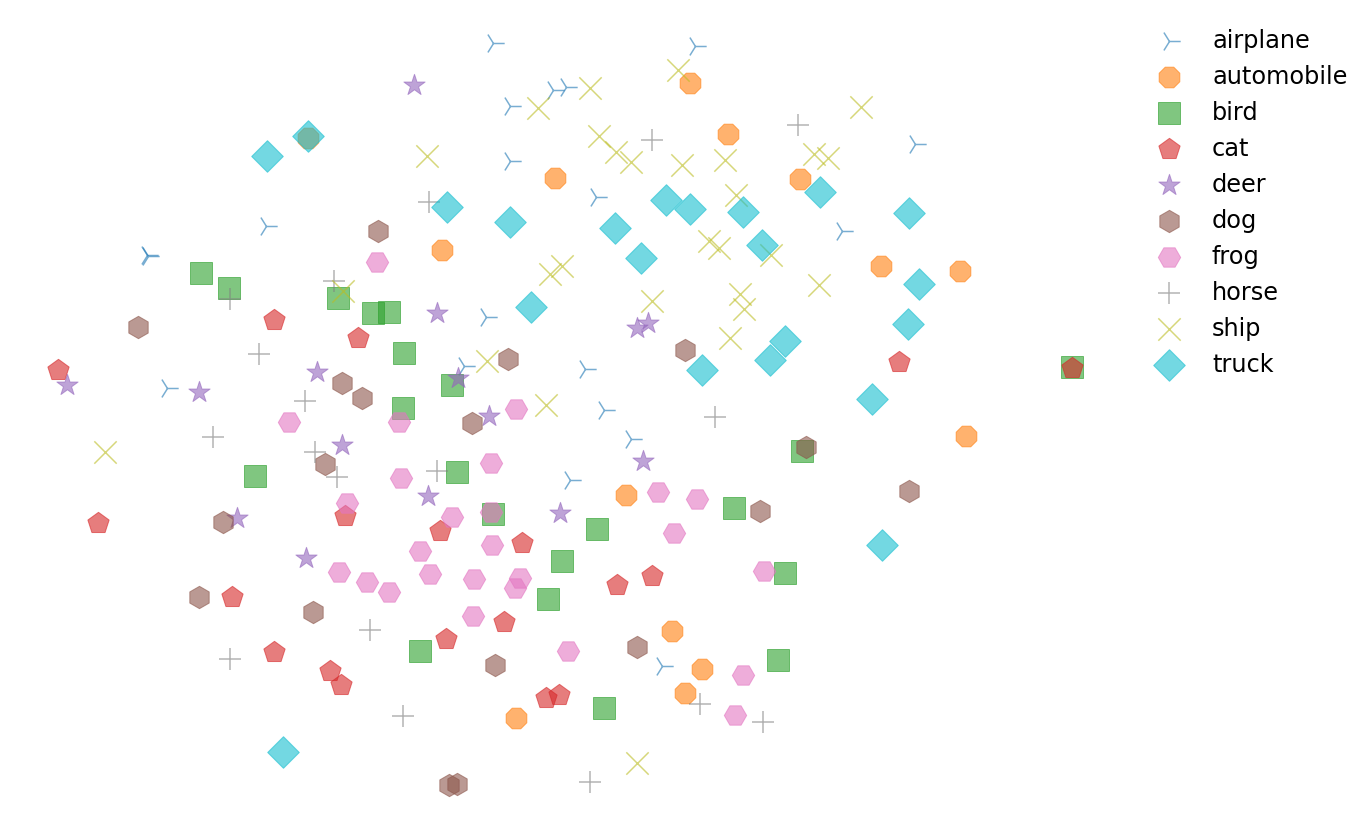

In [8]:
train_eval()